In [7]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import RegexpTokenizer as rt
from stop_words import get_stop_words
import re
from pymystem3 import Mystem

from datetime import datetime, date
import textwrap

sns.set()
mystem = Mystem()

In [8]:
with open('AK_1967_P1.srt', encoding='1251') as file:
    subtitles_1967_part_1 = file.readlines()
    file.close()
with open('AK_1967_P2.srt', encoding='1251') as file:
    subtitles_1967_part_2 = file.readlines()
    file.close()
subtitles_1967 = subtitles_1967_part_1 + subtitles_1967_part_2

In [9]:
def get_clean_subtitles(original_subtitles):
    sub = []
    punct = [".","!","?","..."]
    for line in original_subtitles:
        line = re.sub('\d+.\d+.+\d+.\d+.+|\d.+', '', line)
        if line != '\n':
            sub.append(line)
    whole_text = ''.join(sub)
    whole_text = re.sub('\n', ' ', whole_text)
    whole_text = re.sub('[1-9]', '', whole_text)
    return whole_text

In [10]:
def extract_time_start_end(time_string):
    '''1 вариант'''
    hours_start = int(time_string[:2])
    minutes_start =  int(time_string[3:5])
    seconds_start = float(time_string[6:8] + '.' + time_string[9:12])
    
    hours_end = int(time_string[17: 19])
    minutes_end =  int(time_string[20: 22])
    seconds_end = float(time_string[23: 25] + '.' + time_string[26:29])
    
    seconds_start_time = hours_start * 3600 + minutes_start * 60 + seconds_start
    seconds_end_time = hours_end * 3600 + minutes_end * 60 + seconds_end
    
    '''2 вариант'''
#     start_time = time_string[:8]
#     end_time = time_string[time_string.rfind('-->')+4:time_string.rfind(',')]
            
#     sec_start = int(start_time[:2]) * 3600 + int(start_time[3:5]) * 60 + float(start_time[6:])
#     sec_end = int(end_time[:2]) * 3600 + int(end_time[3:5]) * 60 + float(end_time[6:])
    '''3 вариант'''
    start_time = time_string[:8]
    end_time = time_string[time_string.rfind('-->')+4:time_string.rfind(',')]
    start_time_obj = datetime.strptime(start_time, '%H:%M:%S').time()
    end_time_obj = datetime.strptime(end_time, '%H:%M:%S').time()

    time_difference = datetime.combine(date.today(), end_time_obj) - datetime.combine(date.today(), start_time_obj)
    duration = time_difference.total_seconds()
    
    return seconds_start_time, seconds_end_time, start_time_obj, end_time_obj, duration

In [11]:
def subtitles_to_df(subtitles):
    subtitles_tmp = ['\n'] + subtitles
    df = pd.DataFrame(columns=['line', 'seconds_start', 'seconds_end', 'start', 'end', 'length'])
    if_new_line_mask = np.array(subtitles_tmp) == '\n'
    new_line_indices = np.arange(len(subtitles_tmp))[if_new_line_mask]
    for i, new_line_idx in enumerate(new_line_indices[:-1]):
        line_idx = int(subtitles_tmp[new_line_idx + 1])
        seconds_start, seconds_end, start_time, end_time, duration = extract_time_start_end(subtitles_tmp[new_line_idx + 2])
        line = ''.join(subtitles_tmp[new_line_indices[i] + 3: new_line_indices[i + 1]])
        time_length = duration
        line = re.sub('\n', ' ', line)
        
#         hour, minute, second = start_time/3600 #для 1 варианта
        
        df_row = {
                  'line':  line, 
            'seconds_start': seconds_start, 
            'seconds_end': seconds_end,
                  'start': start_time, 
                  'end': end_time, 
                  'length': time_length}
        
        df = df.append(df_row, ignore_index=True)
    return df

In [12]:
sub_1967_1 = subtitles_to_df(subtitles_1967_part_1)
sub_1967_2 = subtitles_to_df(subtitles_1967_part_2)


In [13]:
sub_1967_1[:6]

,line,seconds_start,seconds_end,start,end,length
0,Хорошо... Хорошо!,159.425,165.261,00:02:39,00:02:45,6.0
1,"Ой, Боже мой!",170.570,172.595,00:02:50,00:02:52,2.0
2,"Вам телеграмма, сударь.",174.841,176.672,00:02:54,00:02:56,2.0
3,Что Дарья Александровна?,178.311,179.972,00:02:58,00:02:59,1.0
4,"Приказала доложить, что она уезжает,",180.246,183.272,00:03:00,00:03:03,3.0
5,"и пускай делают как им... как вам, стало быть,...",183.449,186.850,00:03:03,00:03:06,3.0


In [14]:
def count_words_per_simple_minute(df):
    count = 0
    speech = []
    words_per_minute = ''
    for index, row in df.iterrows():
        words_per_minute = words_per_minute + row['line']
        count = count + row['length']
        if count >= 60:
            speech.append(words_per_minute)
            count = 0
            words_per_minute=''
    return speech

In [15]:
speech_1967_1 = count_words_per_simple_minute(sub_1967_1)
speech_1967_2 = count_words_per_simple_minute(sub_1967_2)

In [16]:
len(speech_1967_1)

30

In [17]:
count_of_words_per_min_1 = [len(line.split()) for line in speech_1967_1]
count_of_words_per_min_2 = [len(line.split()) for line in speech_1967_2]

total_1 = 0
for ele in range(0, len(count_of_words_per_min_1)):
    total_1 = total_1 + count_of_words_per_min_1[ele]

total_2 = 0
for ele in range(0, len(count_of_words_per_min_2)):
    total_2 = total_2 + count_of_words_per_min_2[ele]
    
mean_1 = total_1/len(count_of_words_per_min_1)
mean_2 = total_2/len(count_of_words_per_min_2)
print(mean_1, mean_2)

print(len(count_of_words_per_min_1), len(count_of_words_per_min_2))

124.16666666666667 125.87878787878788
30 33


In [18]:
def get_text_length_by_minutes(subtitels_df, minute_interval=1, ratio=False):
    minutes_2_text = {}
    start_times = subtitels_df['seconds_start'] - subtitels_df['seconds_start'][0]
    current_minute = minute_interval
    current_minute_text = ''
    for i, start in enumerate(start_times):
        
        if start > current_minute * 60:
            minutes_2_text[current_minute] = current_minute_text
            current_minute_text = subtitels_df['line'][i]
            current_minute += minute_interval
        else:
            current_minute_text += subtitels_df['line'][i]
            
       
    for key, value in minutes_2_text.items():
        value = value.split()
        minutes_2_text[key] = len(value)
    
    if ratio:
        minutes_sum = sum(list(minutes_2_text.values()))
        for key, value in minutes_2_text.items():
            minutes_2_text[key] = round(value/minutes_sum, 3)
    
    return minutes_2_text

In [19]:
dict_minutes_2_text_1 = get_text_length_by_minutes(sub_1967_1)
dict_minutes_2_text_2 = get_text_length_by_minutes(sub_1967_2)


In [20]:
sum(list(dict_minutes_2_text_1.values()))/len(list(dict_minutes_2_text_1.values()))

53.27536231884058

In [21]:
sum(list(dict_minutes_2_text_2.values()))/len(list(dict_minutes_2_text_2.values()))

68.33870967741936

In [22]:
def visualize_num_of_words_per_minutes(dict_with_minutes_2_text, title_of_film, color, x_max, y_max,
                                       xticks_interval=5, yticks_interval=10, width=1, linear=True,
                                      polinomial=True):
    plt.style.use('ggplot')
    plt.figure(figsize=(50,25))
    plt.bar(list(dict_with_minutes_2_text.keys()),list(dict_with_minutes_2_text.values()), color=color
            )
    
    plt.xticks(list(dict_with_minutes_2_text.keys())[::xticks_interval], fontsize=24)
    highest_tick = max(list(dict_with_minutes_2_text.values()))
    if isinstance(highest_tick, float) :             
        plt.yticks(np.linspace(0, highest_tick,yticks_interval), fontsize=24)
    else:
        plt.yticks(range(0, highest_tick,yticks_interval), fontsize=24)
    plt.xlabel('Minute of the film', fontsize=28)
    plt.ylabel('Number of words per minute', fontsize=28)
    plt.title(f"Distribution of words' number in screen time of {title_of_film}", fontsize = 42)
    
    if linear:
        x = list(dict_with_minutes_2_text.keys())
        m, b = np.polyfit(x, list(dict_with_minutes_2_text.values()), 1)
        plt.plot(x, m*np.array(x) + b, linewidth=5, color='black')
        
    if polinomial:
        mymodel = np.poly1d(np.polyfit(list(dict_with_minutes_2_text.keys()), list(dict_with_minutes_2_text.values()), 6))
        myline = np.linspace(1, x_max, y_max)
        plt.plot(myline, mymodel(myline), linewidth=10, color='royalblue')
    
    plt.show()

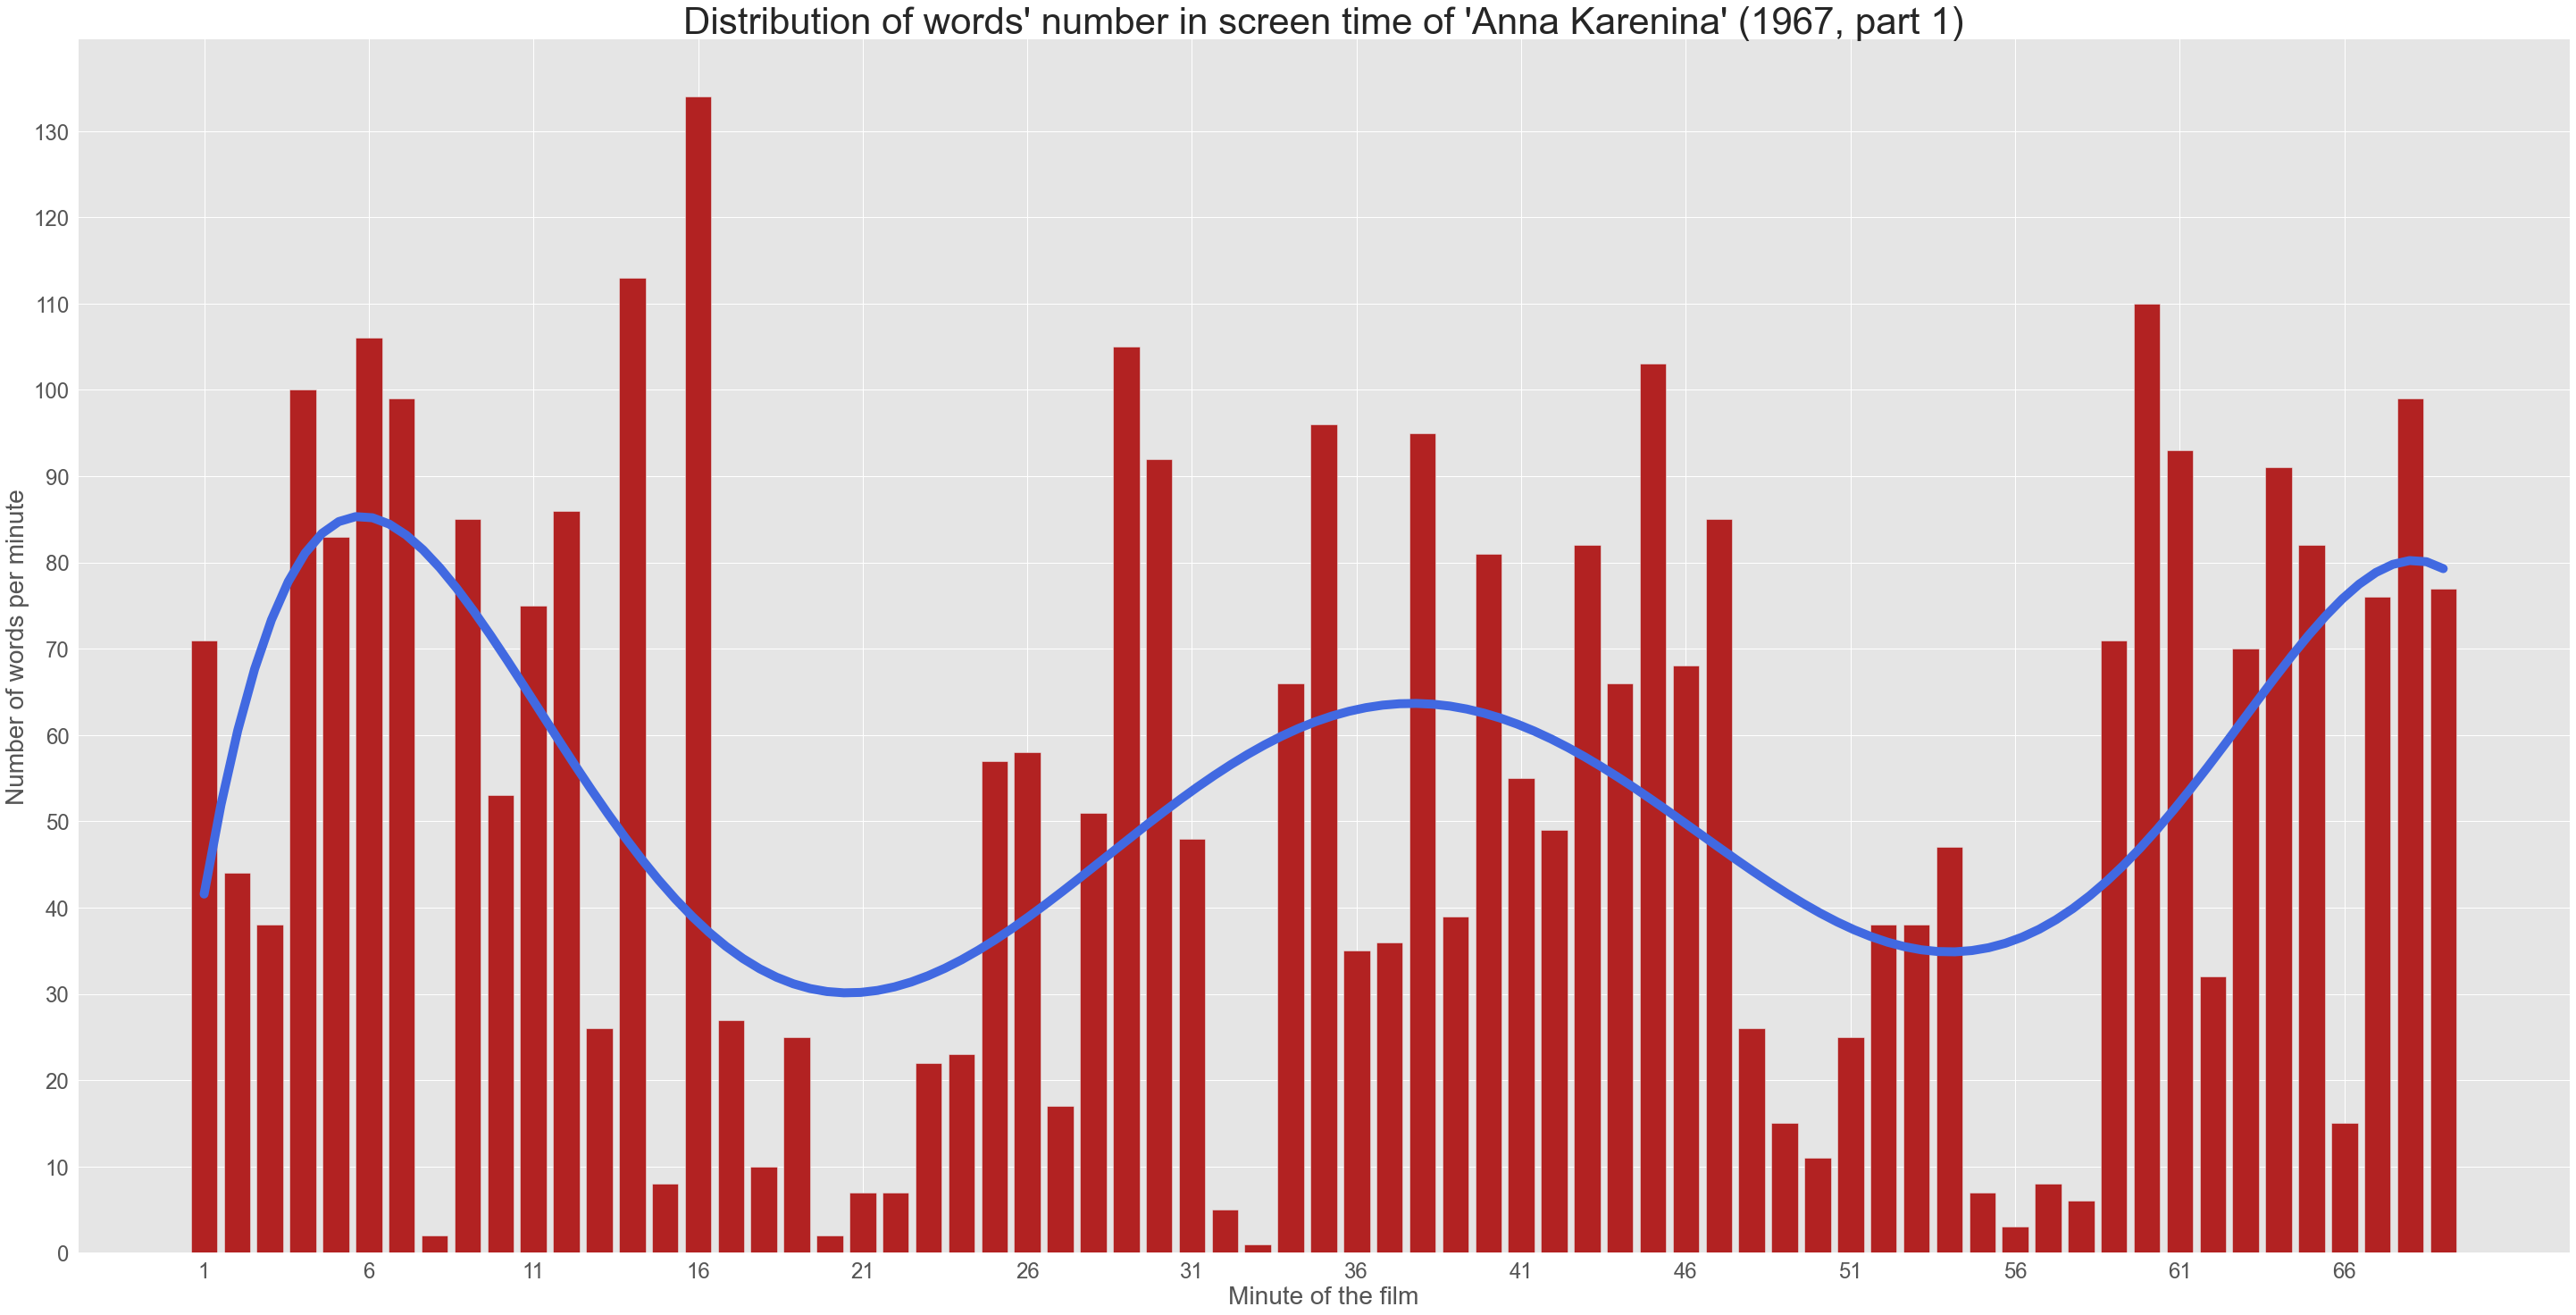

In [23]:
visualize_num_of_words_per_minutes(dict_minutes_2_text_1, "'Anna Karenina' (1967, part 1)", 'firebrick',69, 134, 
                                   linear=False)

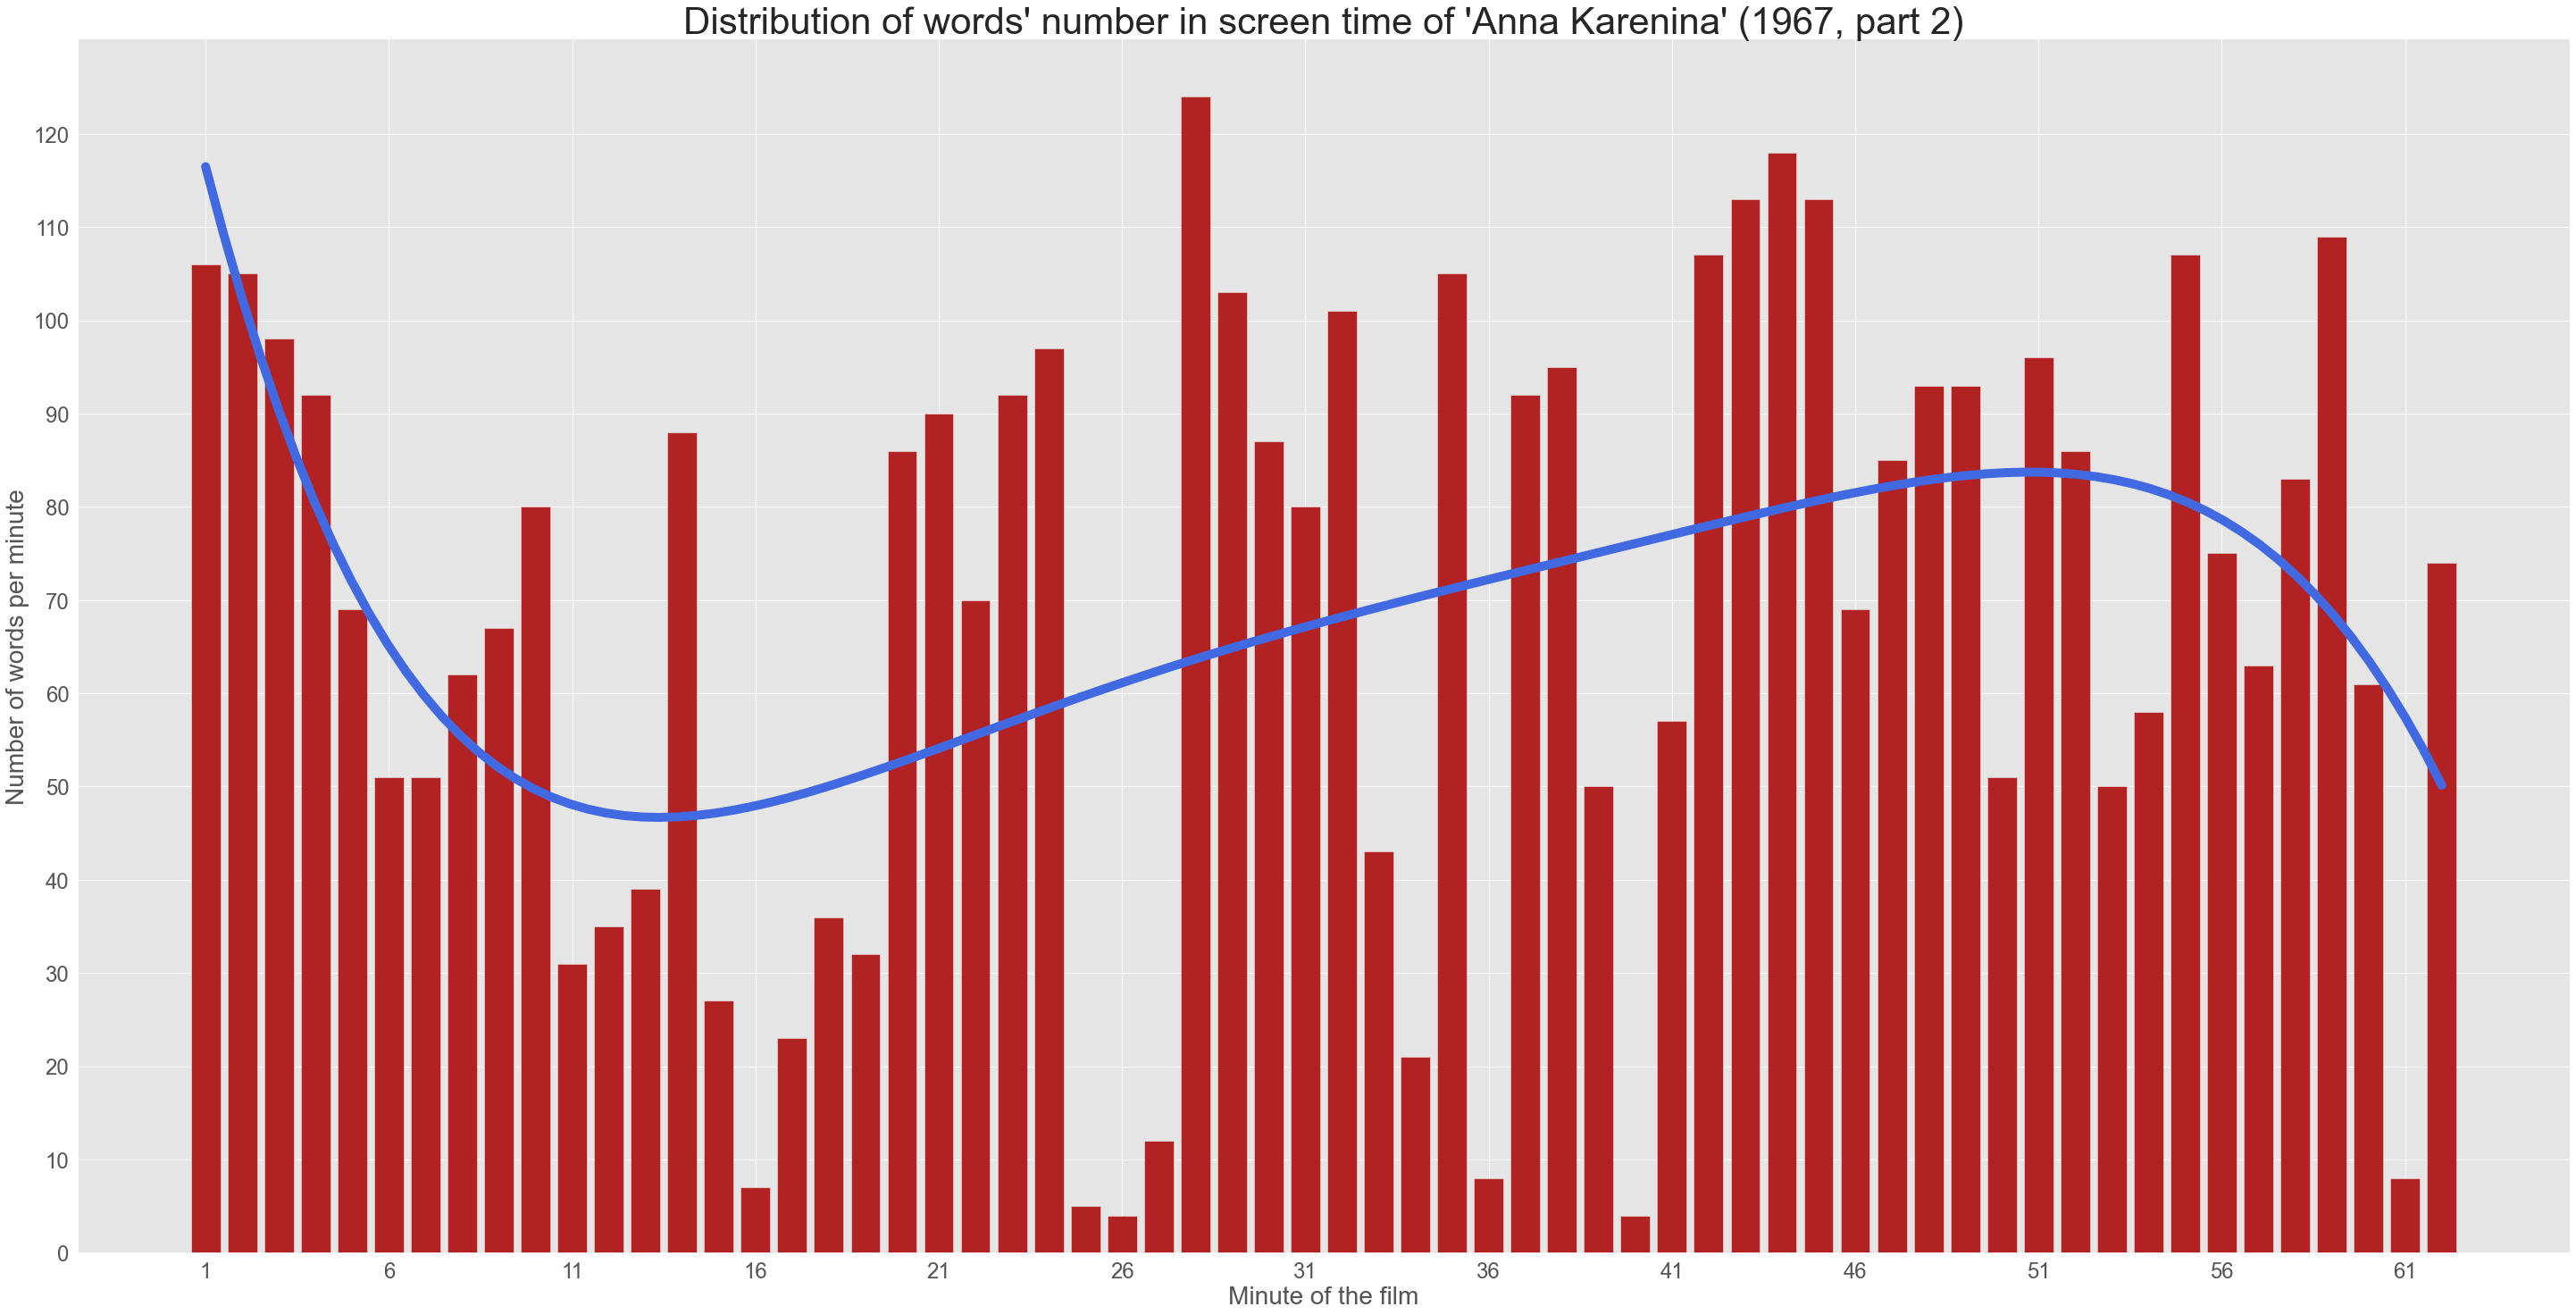

In [24]:
visualize_num_of_words_per_minutes(dict_minutes_2_text_2, "'Anna Karenina' (1967, part 2)", 'firebrick', 
                                   62, 124, linear=False)

In [25]:
with open("Text_Documents/Subtitles_1967.txt", "w") as file:
        file.write(get_clean_subtitles(subtitles_1967))      

# Обработка и разбиение текстов на три части

## Загрузка текстов

In [26]:
with open('Text_Documents/Reported_and_Directed_speech_in_Anna_Karenina.txt') as file:
    whole_speech = file.read()
    file.close()
with open('Text_Documents/Subtitles_1967.txt') as file:
    whole_subs = file.read()
    file.close()

## Вычленение именованных сущностей

In [27]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)


segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [28]:
text = whole_speech
doc = Doc(text)

In [29]:
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.tag_ner(ner_tagger)

In [30]:
for span in doc.spans:
    span.normalize(morph_vocab)
dict_of_names_in_novel = {_.text: _.normal for _ in doc.spans if _.text != _.normal}

In [31]:
dict_of_names_in_novel

{'Дармштадте': 'Дармштадт',
 'Америке': 'Америка',
 'Дарье Александровне': 'Дарья Александровна',
 'Анны Аркадьевны': 'Анна Аркадьевна',
 'Пензенского губернского правления': 'Пензенский губернское правление',
 'Сергея Иваныча': 'Сергей Иваныч',
 'Кознышева': 'Кознышев',
 'Гурину': 'Гурин',
 'Каразинском уезде': 'Каразинский уезд',
 'Зоологическом саду': 'Зоологический сад',
 'Кейсом': 'Кейс',
 'Стало': 'Ставшее',
 'Москве': 'Москва',
 'Трубину': 'Трубин',
 'Англию': 'Англия',
 'Англии': 'Англия',
 'Эрмитаже': 'Эрмитаж',
 'Гриневича': 'Гриневич',
 'Москвы': 'Москва',
 'Москву': 'Москва',
 'Постой': 'Постоявший',
 'Вронского': 'Вронский',
 'Поезжай': 'Поехавший',
 'Петербурга': 'Петербург',
 'Ницце': 'Ницца',
 'Константина Дмитрича': 'Константин Дмитрич',
 'Игнатовым': 'Игнатов',
 'Облонского': 'Облонской',
 'Анну': 'Анна',
 'Каренину': 'Каренина',
 'Алексея Александровича': 'Алексей Александрович',
 'Левиным': 'Левин',
 'Левина': 'Левин',
 'Вдове': 'Вдова',
 'Сереже': 'Сережа',
 'Стива

In [32]:
subs = whole_subs
doc_subs = Doc(subs)

In [33]:
doc_subs.segment(segmenter)
doc_subs.tag_morph(morph_tagger)
doc_subs.tag_ner(ner_tagger)

In [34]:
for span in doc_subs.spans:
    span.normalize(morph_vocab)
dict_of_names_in_subs = {_.text: _.normal for _ in doc_subs.spans if _.text != _.normal}

In [35]:
lst_of_names_in_novel = [name.lower() for name in list(dict_of_names_in_novel.values())]
lst_of_names_in_subs = [name.lower() for name in list(dict_of_names_in_subs.values())]

In [36]:
names_in_novel = ' '.join(lst_of_names_in_novel).split()
names_in_subs = ' '.join(lst_of_names_in_subs).split()

## Устранение стоп-слов, лемматизация и прочее

In [37]:
'''Подгружаю стоп-слова и пунктуацию'''
stop_words = []
for elem in get_stop_words('ru'):
    if isinstance(elem, list):
        stop_words += elem
    else:
        stop_words.append(elem)
        
for letter in range(1072,1104):
        stop_words.append(chr(letter))

for letter in range(33,128):
    stop_words.append(chr(letter))
    
stop_words = stop_words + names_in_novel
stop_words = stop_words + names_in_subs
nicks = ['долли', 'кити', 'алабин','12','13','28','Alexandre','All',
        'Berthe','Bonne','Chateâu','Honni','Il','Linon','Louis',
         'Mademoiselle','Maman','Marie','Mariette','Pardon','Please',
         'Poésie','Roland','Tant','Tiny','Tout','Un','XV','amour',
         'bear','belle','elle','bijou','blague','mio','tesoro','Il',
        'bonne','cancan','chance','chat','Cela', 'pas', 'plus', 'fin', 'que','cher','chère','compagne',
         'cosy','dame','des','diable','enfers','engouements','entendons',
        'est','faut','filez','fleurs','genre','grand','have','in',
        'jamais','le','line','landau','mais','ll','lle','ma','madame','mademoiselle',
        'mal','maman','merci','mesdames','mieux','mio','mon','more','my','ne',
        'not','nous','outrer','pardon','parfait','pense','pluck','précision',
        'qui','quo','ridicule','rien','right','rose','sa','sir','skeletons',
        'soeur','soit','some','status','tant','tesoro','une','vous','we','ça','fardeau',
         'terrе','blanche','Аll','Entrez','Charmante','Mais', 'était', 'délicieux',
         'cеnséquence','Ça', 'tire', 'pas','venez', 'vite','Jules','Landau','fameux','Jules','Landau',
         'clair','voyant','oncle','Les', 'amis', 'de', 'nos',  'sont']
stop_words = stop_words+nicks
    
stop_words = set(stop_words)
deleter_punct = rt('\w+')

special_characters = "qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM"

In [38]:
def processed_text(original_text):
    lemmas = ' '.join(mystem.lemmatize(original_text))
    tokens = deleter_punct.tokenize(lemmas)
    without_punct_and_stopwords = []
    for word in tokens:
        if word not in stop_words:
            if any(c in special_characters for c in word)==False:
                without_punct_and_stopwords.append(word)
    text = ' '.join(without_punct_and_stopwords)
    return without_punct_and_stopwords, text

In [39]:
punct_stop_speech, whole_speech = processed_text(whole_speech)
speech = textwrap.wrap(whole_speech, len(whole_speech)/3)
first_part = speech[0]
second_part = speech[1]
third_part = speech[2]
lst_texts = [first_part, second_part, third_part]

In [40]:
punct_stop_subs, whole_subs = processed_text(whole_subs)
subs = textwrap.wrap(whole_subs, len(whole_subs)/3)
first_part_subs = subs[0]
second_part_subs = subs[1]
third_part_subs = subs[2]
lst_subs = [first_part_subs, second_part_subs, third_part_subs]

In [41]:
def save_text(text, index):
    with open("Text_Documents/Novel_part_{}.txt".format(index), "w") as file:
        file.write(text)
def save_subtitles(text, index):
    with open("Text_Documents/Subtitles_part_{}.txt".format(index), "w") as file:
        file.write(text)

In [42]:
def save_tokens(lst, name):
    with open("Text_Documents/tokens_{}.txt".format(name), "w") as file:
        for line in lst:
            file.write(line+'\n')

In [43]:
for index, text in enumerate(lst_texts):
    save_text(text, index+1)
for index, text in enumerate(lst_subs):
    save_subtitles(text, index+1)

In [44]:
save_tokens(punct_stop_speech, 'novel')
save_tokens(punct_stop_subs, 'sub')

In [45]:
documents = lst_texts+lst_subs

In [46]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [47]:
processed_docs = chunkIt(punct_stop_speech, 3) + chunkIt(punct_stop_subs, 3)

In [48]:
[len(leng) for leng in processed_docs]

[8989, 8990, 8990, 984, 985, 985]

# Topic Modeling with Mallet (based on the texts got in the previous part of notebook)

In [49]:
topics = pd.read_csv('topics_in_docs_6.csv', header=None, index_col=None, sep = '\t' )

In [50]:
topics

,0,1,2,3,4,5,6,7
0,0,file:/Users/tonleon/Desktop/mallet-2.0.8/subti...,0.478151,0.009396,0.022021,0.024079,0.036033,0.430320
1,1,file:/Users/tonleon/Desktop/mallet-2.0.8/subti...,0.000151,0.002081,0.266022,0.000110,0.000165,0.731471
2,2,file:/Users/tonleon/Desktop/mallet-2.0.8/subti...,0.091955,0.000005,0.189021,0.000012,0.000018,0.718989
3,3,file:/Users/tonleon/Desktop/mallet-2.0.8/subti...,0.001478,0.203412,0.000011,0.000012,0.100766,0.694320
4,4,file:/Users/tonleon/Desktop/mallet-2.0.8/subti...,0.000152,0.000043,0.000102,0.281122,0.000167,0.718414
5,5,file:/Users/tonleon/Desktop/mallet-2.0.8/subti...,0.000148,0.000042,0.000099,0.000108,0.247535,0.752067
6,6,file:/Users/tonleon/Desktop/mallet-2.0.8/subti...,0.013647,0.000005,0.000011,0.205363,0.057129,0.723846


In [51]:
'''переименовываю для удобства первую колонку'''
topics[1] = topics[1].apply(lambda x: x[-16: -4] if x.find('Novel') != -1 else x[-20: -4])

In [52]:
'''дропаю колонку с индексами, а то она дублируется'''
topics = topics.drop(0, axis = 1)
# topics = topics.drop(13, axis = 1)
topics = topics.drop([0])

In [53]:
topics = topics.rename(columns = {1: 'Text'})
topics = topics.rename(columns = {i + 1 : i for i in range(1, 14)})
topics = topics.sort_values(by=['Text'])
topics

,Text,1,2,3,4,5,6
2,Novel_part_1,0.091955,0.000005,0.189021,0.000012,0.000018,0.718989
6,Novel_part_2,0.013647,0.000005,0.000011,0.205363,0.057129,0.723846
3,Novel_part_3,0.001478,0.203412,0.000011,0.000012,0.100766,0.694320
1,Subtitles_part_1,0.000151,0.002081,0.266022,0.000110,0.000165,0.731471
4,Subtitles_part_2,0.000152,0.000043,0.000102,0.281122,0.000167,0.718414
5,Subtitles_part_3,0.000148,0.000042,0.000099,0.000108,0.247535,0.752067


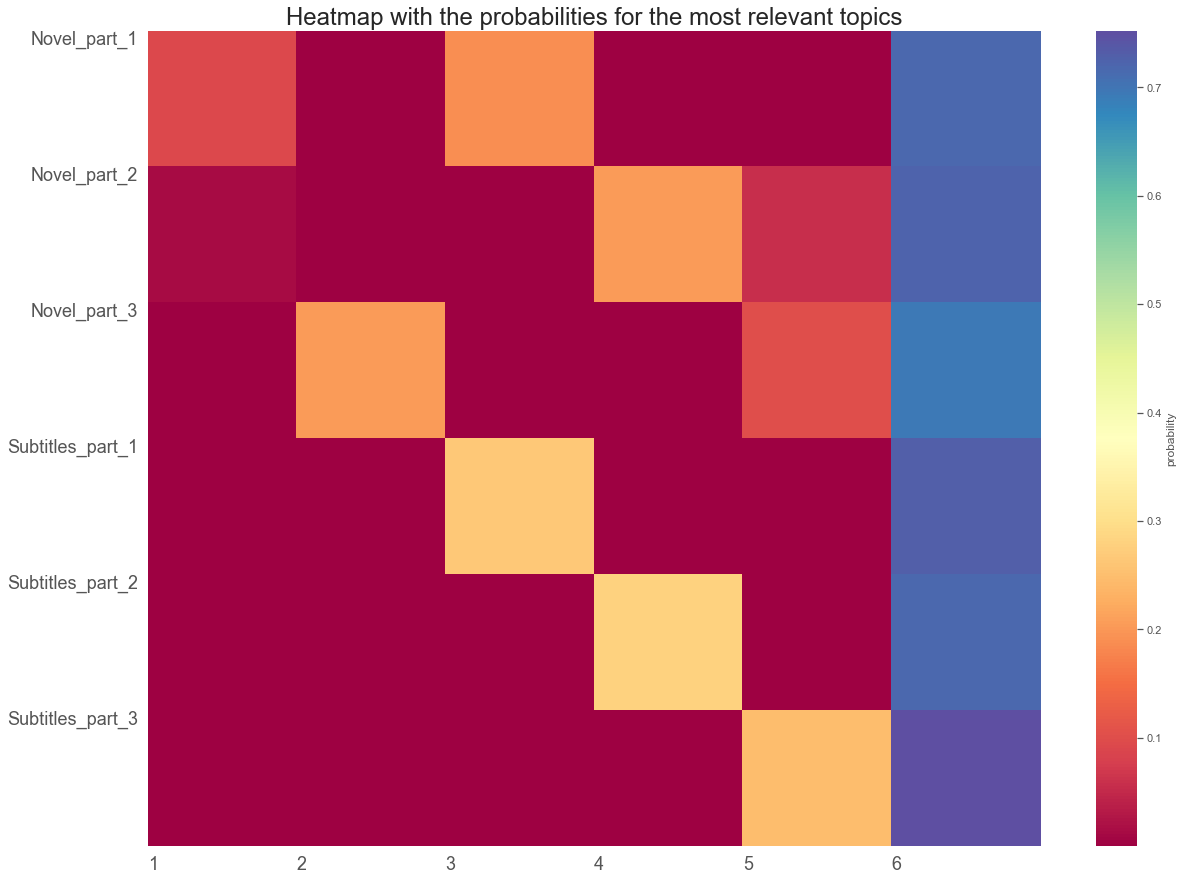

In [54]:
plt.figure(figsize = (20, 15)) 
Index= [i for i in range(1, 7)]
Cols = list(topics['Text'])
m = np.array(topics[topics.columns[1:6]])

sns.heatmap(topics.iloc[:, 1:], cmap='Spectral', cbar_kws={'label': 'probability'}, xticklabels=Index, yticklabels=Cols)
plt.xticks(np.arange(len(Index)),Index, fontsize=18,horizontalalignment='left')
plt.yticks(np.arange(len(Cols)),Cols, fontsize=18, verticalalignment='top', rotation=360) 
plt.title('Heatmap with the probabilities for the most relevant topics', fontsize=24)


# for i in range(len(Cols)):
#         for j in range(len(Index)):
#             text = ax.text(j, i, round(m[i,j],2),horizontalalignment='left',
#                            verticalalignment='top', fontsize=16)
plt.show()


In [56]:
words_of_topics = pd.read_csv('output_keys_6.csv', header=None, index_col=None, sep = '\t' )
words_of_topics[0] = words_of_topics[0].apply(lambda x: x+1)
words_of_topics

,0,1,2
0,1,"0,1479",научать поездка тюрбо петь ужасный дуэль прест...
1,2,"0,04221",война разум церковь знание ответ движение запи...
2,3,"0,09892",скучно выпивать бал кататься фру хотеться мане...
3,4,"0,10817",умирать рабочий образование раб развод позволя...
4,5,"0,16186",друг понравиться пользоваться особенность близ...
5,6,"1,93304",знать говорить думать свой понимать видеть нич...


In [57]:
topic_weights = pd.read_csv('topic_weight_6.сsv', header=None, index_col=None, sep = '\t' )

In [58]:
def get_the_most_freq_words_of_the_topic(topic_weights, n_of_words, n_of_topic):
    highest_freq = topic_weights.groupby(0)[2].nlargest(n_of_words)
    return topic_weights.iloc[highest_freq[n_of_topic].index][[2, 1]]

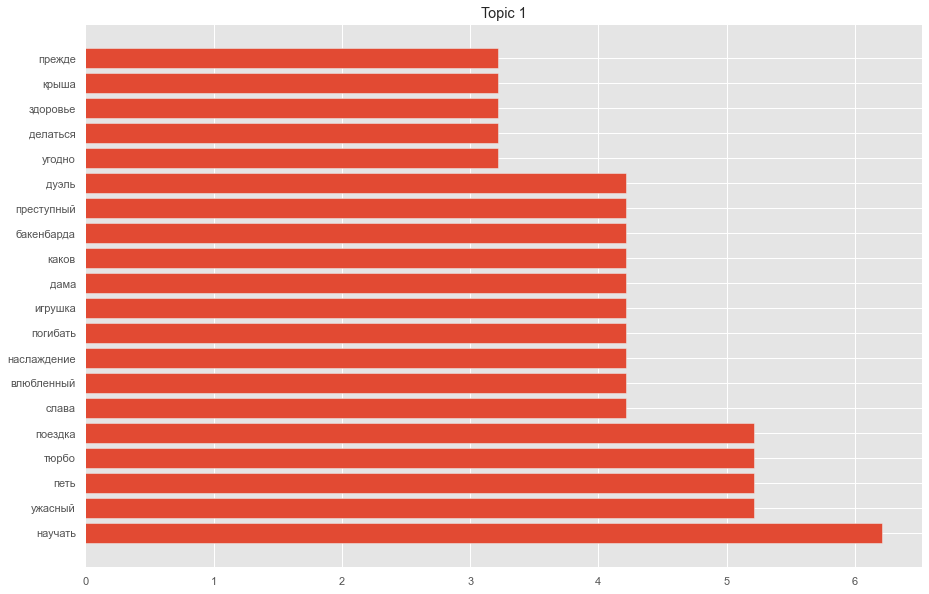

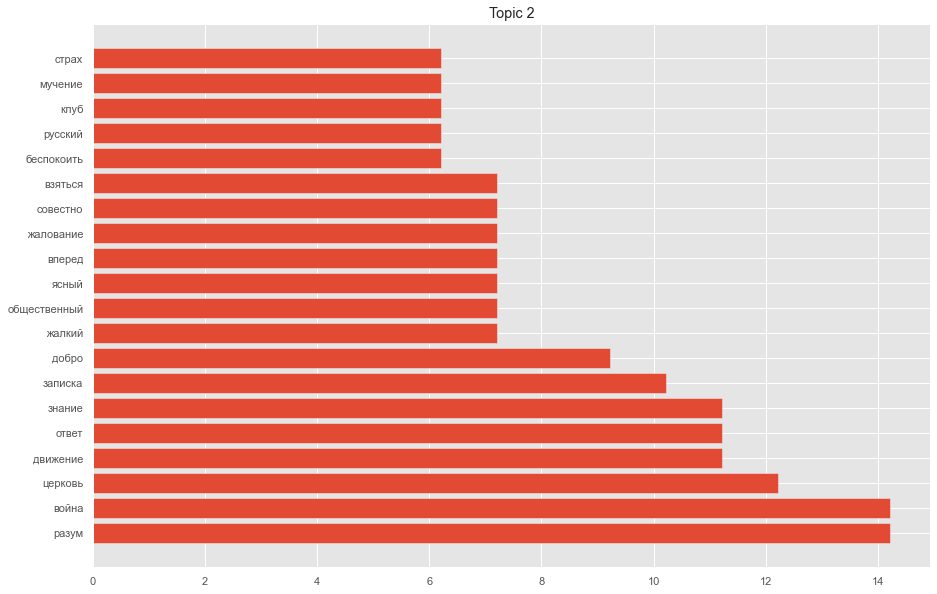

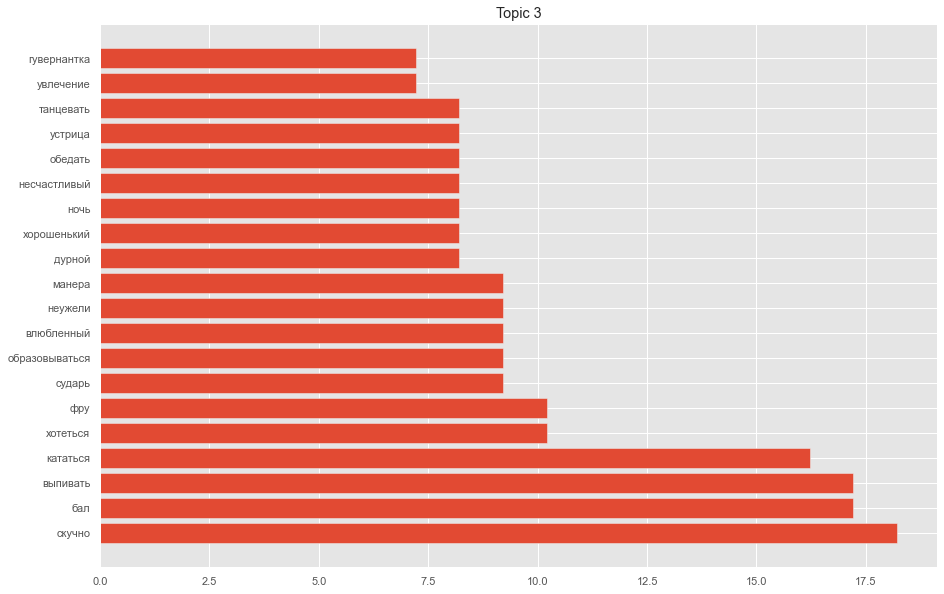

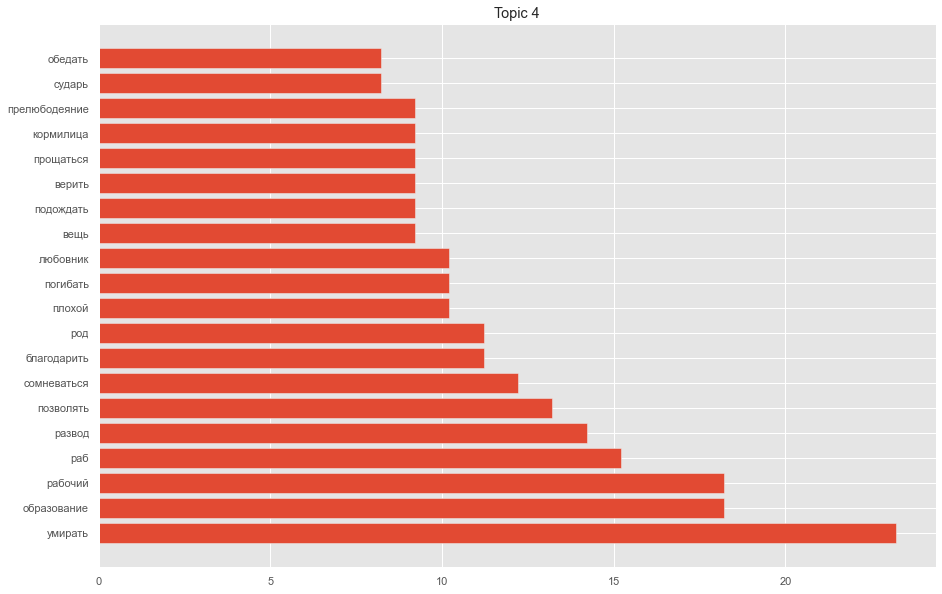

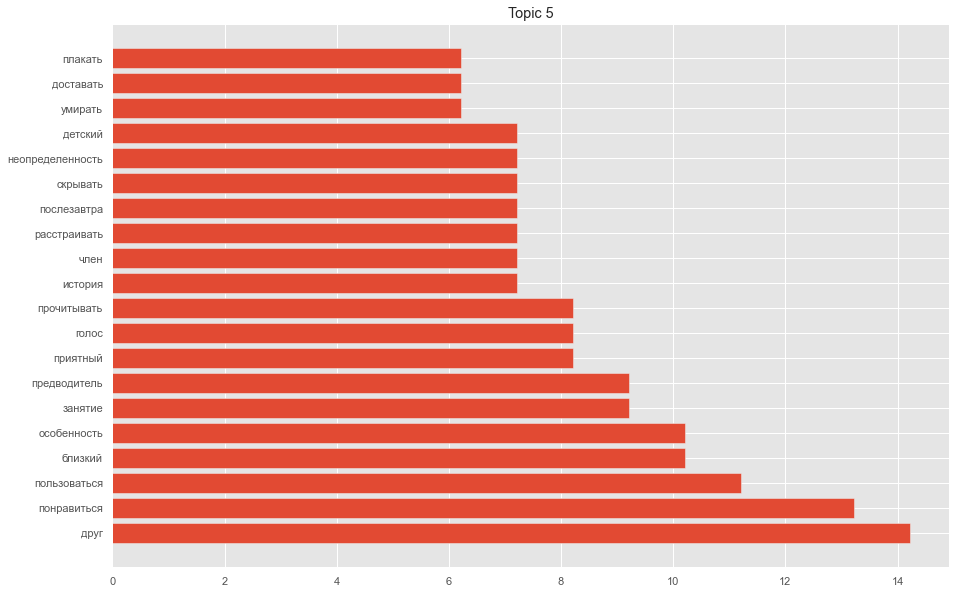

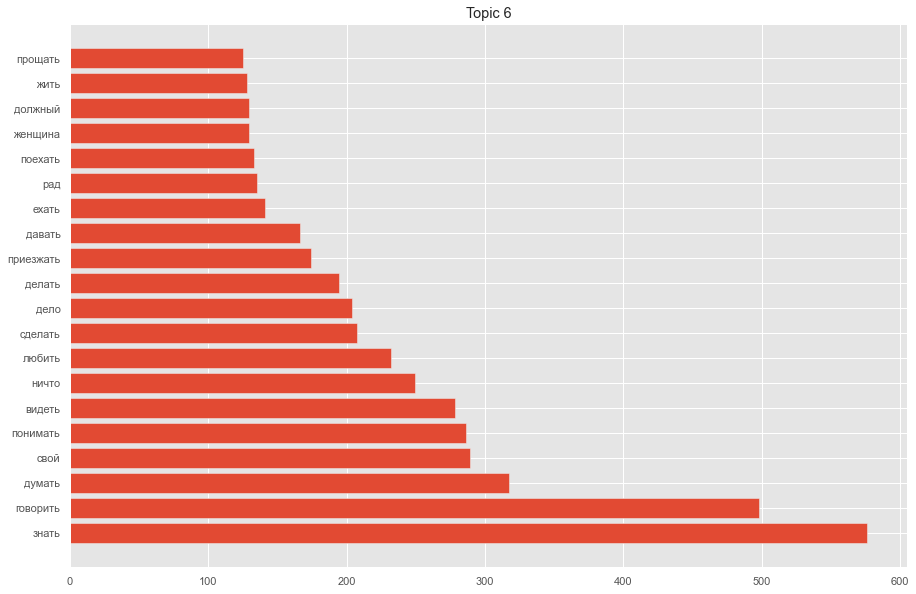

In [59]:
for i in range(6):
    plt.figure(figsize=(15,10))
    vis = get_the_most_freq_words_of_the_topic(topic_weights, 20, i)
    plt.barh(vis[1], vis[2])
    plt.xticks
    plt.title('Topic {}'.format(i+1))
    plt.show()

# Text Similarity

In [60]:
def open_doc(path_to_doc, encoding):
    with open(path_to_doc, encoding = encoding) as file:
        text = file.read()
        file.close()
    return text

In [48]:
novel_part_1 = open_doc('Text_documents/Reported_and_Directed_speech_in_Anna_Karenina_Part_1.txt', 'utf8')
novel_part_2 = open_doc('Text_documents/Reported_and_Directed_speech_in_Anna_Karenina_Part_2.txt', 'utf8')
novel_part_3 = open_doc('Text_documents/Reported_and_Directed_speech_in_Anna_Karenina_Part_3.txt', 'utf8')
novel_part_4 = open_doc('Text_documents/Reported_and_Directed_speech_in_Anna_Karenina_Part_4.txt', 'utf8')
novel_part_5 = open_doc('Text_documents/Reported_and_Directed_speech_in_Anna_Karenina_Part_5.txt', 'utf8')
novel_part_6 = open_doc('/Users/tonleon/Desktop/Diploma/Reported_and_Directed_Speech/Reported_and_Directed_speech_in_Anna_Karenina_Part_6.txt', 'utf8')
novel_part_7 = open_doc('/Users/tonleon/Desktop/Diploma/Reported_and_Directed_Speech/Reported_and_Directed_speech_in_Anna_Karenina_Part_7.txt', 'utf8')
novel_part_8 = open_doc('/Users/tonleon/Desktop/Diploma/Reported_and_Directed_Speech/Reported_and_Directed_speech_in_Anna_Karenina_Part_8.txt', 'utf8')
novel_parts = [novel_part_1, novel_part_2,novel_part_3,novel_part_4,
                   novel_part_5,novel_part_6,novel_part_7,novel_part_8]


In [49]:
lst_novel_parts = []
for part in novel_parts:
    _, novel = processed_text(part)
    lst_novel_parts.append(novel)

In [85]:
str_1967_1 = get_clean_subtitles(subtitles_1967_part_1)
str_1967_2 = get_clean_subtitles(subtitles_1967_part_2)
lst_1967 = str_1967_1.split() + str_1967_2.split()

proc_subs = [' '.join(tokens) for tokens in chunkIt(lst_1967,3)]

processed_subs = [' '.join(sub) for sub in processed_docs[3:6]]

    
all_texts = lst_novel_parts+processed_subs

In [71]:
len(chunkIt(lst_1967,3)[2])

2663

In [123]:
dict_to_vis_sub_novel = {}
nums_of_len = []
for text in all_texts:
    nums_of_len.append(len(text.split()))
    
for i, text in enumerate(nums_of_len):
    dict_to_vis_sub_novel[i]=nums_of_len[i]
    
sum(dict_to_vis_sub_novel.values())

30944

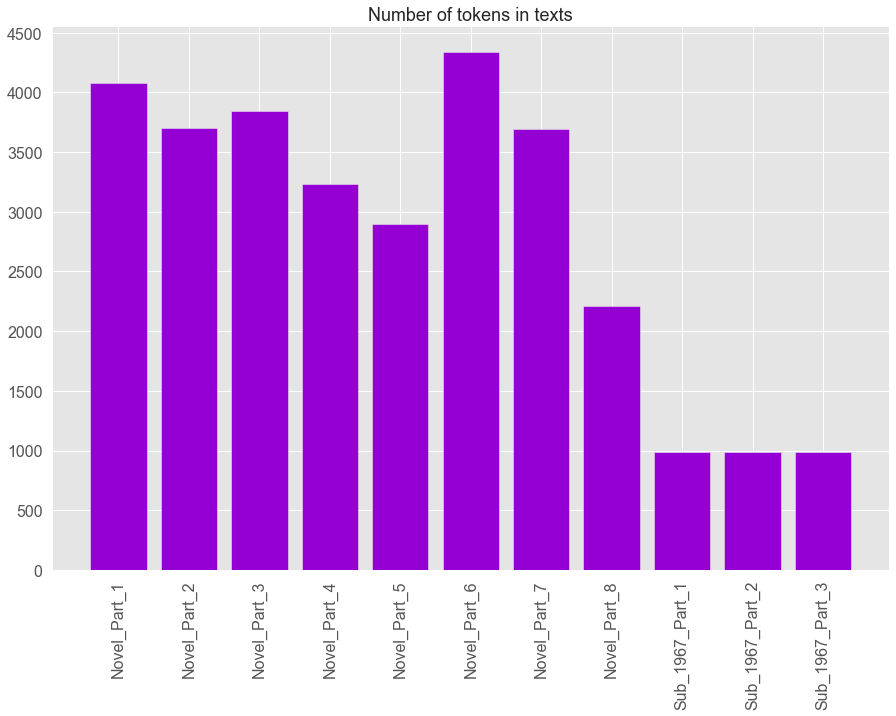

In [107]:
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
labels = ["Novel_Part_1","Novel_Part_2","Novel_Part_3","Novel_Part_4","Novel_Part_5",
            "Novel_Part_6","Novel_Part_7","Novel_Part_8","Sub_1967_Part_1","Sub_1967_Part_2",
            "Sub_1967_Part_3"]
plt.bar(dict_to_vis_sub_novel.keys(), dict_to_vis_sub_novel.values(), color='darkviolet')
plt.xticks(np.arange(len(labels)), labels, rotation=90, fontsize=16)
plt.yticks(np.arange(0, 5000, 500), fontsize=16)
plt.title('Number of tokens in texts', fontsize=18)

plt.show()

In [55]:
tfidf = TfidfVectorizer().fit_transform(all_texts)
# no need to normalize, since Vectorizer will return normalized tf-idf
pairwise_similarity = tfidf * tfidf.T

In [112]:
tfidf.toarray().shape

(11, 5428)

In [56]:
tfidf_ak = pd.DataFrame(data=pairwise_similarity.toarray() , index=["Novel_Part_1","Novel_Part_2",
                                                              "Novel_Part_3","Novel_Part_4","Novel_Part_5",
                                                                    "Novel_Part_6","Novel_Part_7",
                                                              "Novel_Part_8","Sub_1967_Part_1","Sub_1967_Part_2",
                                                                    "Sub_1967_Part_3"], 
                  columns=["Novel_Part_1","Novel_Part_2",
                           "Novel_Part_3","Novel_Part_4","Novel_Part_5","Novel_Part_6","Novel_Part_7",
                           "Novel_Part_8","Sub_1967_Part_1","Sub_1967_Part_2", "Sub_1967_Part_3"])

In [57]:
mask = np.triu(np.ones_like(tfidf_ak, dtype=bool))

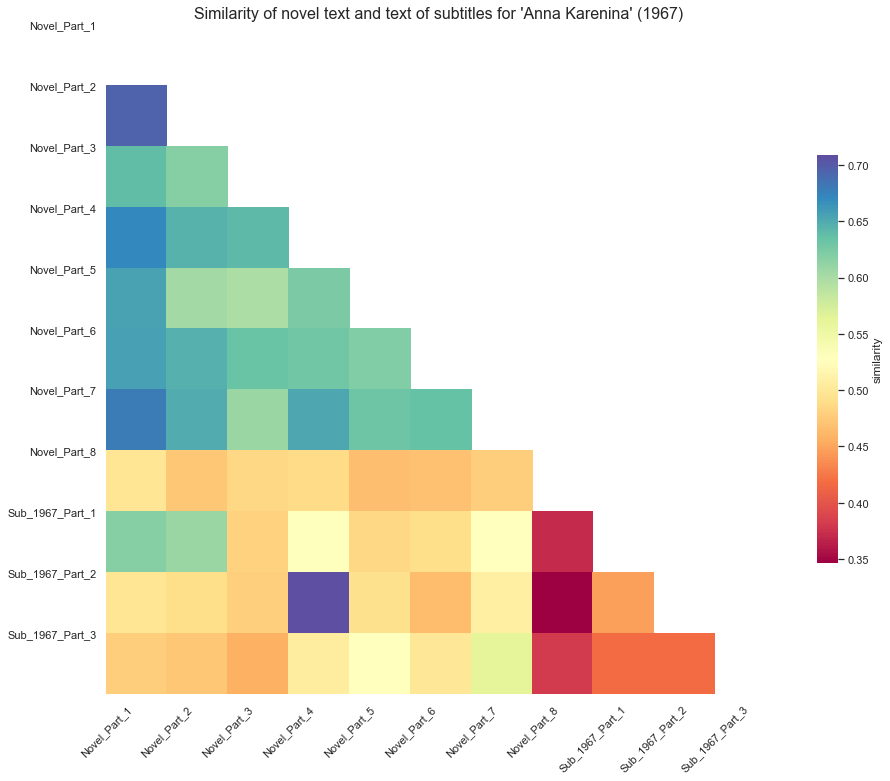

In [128]:
plt.figure(figsize = (15, 15)) 
Index= list(tfidf_ak.columns)
Cols = list(tfidf_ak.columns)
t = np.array(tfidf_ak)

sns.set_theme(style="white")

sns.heatmap(tfidf_ak.iloc[:, :],mask=mask,cbar_kws={'label': 'similarity',"shrink": .5}, cmap='Spectral', 
            xticklabels=Index, yticklabels=Cols, square=True)
plt.yticks(np.arange(len(Cols)), Cols) 
plt.xticks(np.arange(len(Index)), Index, rotation=45) 
plt.title("Similarity of novel text and text of subtitles for 'Anna Karenina' (1967) ", fontsize = 16)
# plt.xticklabels(Index, fontdict={'fontsize':18}, rotation = 45)
# plt.yticklabels(Cols, fontdict={'fontsize':18, 'verticalalignment': 'top'})
# for i in range(len(Cols)):
#         for j in range(len(Index)):
#             text = ax.text(j, i, round(t[i,j], 2),horizontalalignment='left',
#                            verticalalignment='top', fontsize=14)
plt.show()